# Investigating Failure Modes and Enhancements of Physics-Informed Neural Networks for Power System Dynamics

## PINN Numerical Experiments and Enhancements

#### Karan Kataria
#### Supervisor: Dr. Subhash Lakshminarayana

In [ ]:
import sys
import os

# Add ODE_numerical_solver module to PATH variable
sys.path.insert(
    1,
    "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/PINNs_PSs/src/numerical_experiments"
)

sys.path.insert(
    2,
    "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/PINNs_PSs/src/numerical_solutions"
)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import scienceplots
from tqdm import tqdm
from scipy.stats import qmc
from torchinfo import summary
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from pyhessian import hessian
from matplotlib.ticker import ScalarFormatter

from utils import set_global_seed, mean_gradient, absolute_max_gradient, grad_norm, loss_grad
from pinn_architecture import PINN
from loss_functions import *
from global_constants import *
from ODE_numerical_solver import swing_ODEs_solver

## 1.0) Set up script

In [ ]:
# Config matplotlib and define plot constants
plt.style.use("science")
plt.rcParams["text.usetex"] = True

# Color map for the visualisations
CMAP: str = "seismic"

# Device to perform tensor operations on (GPU to CPU)

# NB: GPUs were not needed; MPS was avaliable on my Mac but did not showcase significant
# computational benefits
DEVICE: str = "cpu"

In [47]:
# Define and fix seed
SEED: int = 10
set_global_seed(SEED)

assert type(SEED) is int

print(f"Seed set: {SEED}")

Seed set: 10


In [48]:
# Specify the parameter to be varied and its symbol
VARYING_PARAM: str = "damping"
VARYING_PARAM_NOTATION: str = "$d$"
print(f"Parameter: {VARYING_PARAM}")

Parameter: damping


In [ ]:
# Root directory to save images and data in
PATH_TO_IM_DIR: str = "/Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick"\
                    f"/PINNs_PSs/data/visualisations/loss_landscapes/{VARYING_PARAM}/"

print(f"Absolute Export Path: {PATH_TO_IM_DIR}")

### 1.1) Set flags

In [50]:
# Boolean constant only adds title on subplots on the top most row
TOP_PLOT: bool = True

# Toggle flag on whether or not to export data and images
SAVE: bool = False

# Toggle flag on whether or not to implement the R3 algorithm proposed by Daw et al. 2023
R3_ALGO: bool = False

# Toggle flag on whether or not to implement the adaptive weight algorithm proposed by Wang et al. 2020
ADAPTIVE_ALGO: bool = False

# Toggle flag on whether or not to implement semi-supervised learning
DATA_LOSS: bool = False

print(f"Plots and files are exported from this file?\t{SAVE}")
print(f"R3 algorithm enabled?\t{R3_ALGO}")
print(f"Adaptive loss weight algorithm enabled?\t{ADAPTIVE_ALGO}")
print(f"Semi-supervised learning enabled?\t{DATA_LOSS}")

Plots and files are exported from this file?	False
R3 algorithm enabled?	False
Adaptive loss weight algorithm enabled?	False
Semi-supervised learning enabled?	False


### 1.2) Initialise SMIB swing equation parameters and loss term weights, including variable parameter and its values

In [ ]:
# Param dictionary
PARAM_DICT: dict = {
    "DAMPING": [0.00015, 0.0015, 0.015, 0.15, 1.5],
    "INERTIA": [0.01, 0.1325, 0.250, 0.3775, 0.5],
    "PHYSICS_WEIGHT": [1e-2, 1e-1, 1e0, 1e1, 1e2],
    "MECHANICAL_POWER": [0.0, 0.0475, 0.095 , 0.1425, 0.19]
}

# Specify the range of parameter values
PARAM_LIST: list[float] = PARAM_DICT[VARYING_PARAM.upper()]

# DAMPING: torch.Tensor = torch.tensor(data=[[0.15]])
INERTIA: torch.Tensor = torch.tensor(data=[[0.25]])
PHYSICS_WEIGHT: torch.Tensor = torch.tensor(data=[[1.0]])
IC_WEIGHT: torch.Tensor = torch.tensor(data=[[1.0]])
MECHANICAL_POWER: torch.Tensor = torch.tensor(data=[[0.13]])

# Initialise training data loss weight for semi-supervised learning
if DATA_LOSS:
    DATA_WEIGHT: torch.Tensor = torch.tensor(data=[[1.0]])

In [52]:
print(f"IC weight: {IC_WEIGHT.item()}")

if VARYING_PARAM != "physics_weight":
    print(f"Physics weight: {PHYSICS_WEIGHT.item()}")

if DATA_LOSS:
    print(f"Data weight: {DATA_WEIGHT.item()}")

IC weight: 1.0
Physics weight: 1.0


### 1.3) Create subdirectories required for data export (continue if already created)

In [53]:
# Ensure desired folder has all intended subdirectories to store the results in
parent_dir = f"{PATH_TO_IM_DIR}/pinn/"

# Define all subdirectories to be created
required_subdirs = [
    "l2_errors",
    "pinn_pred_vs_rk45",
    "rel_error_per_epoch",
    "training_loss",
    "gradient_norms",
    "l2_errors/semi_supervised"
]

# Create subdirectories if not existent, else continue
for subdir in required_subdirs:
    full_path = os.path.join(parent_dir, subdir)
    if not os.path.exists(full_path):
        os.makedirs(full_path, exist_ok=True)
        print(f"Created: {full_path}")
    else:
        print(f"Already exists: {full_path}")

Created: /Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/PINNs_PSs/data/visualisations/loss_landscapes/damping//pinn/l2_errors
Created: /Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/PINNs_PSs/data/visualisations/loss_landscapes/damping//pinn/pinn_pred_vs_rk45
Created: /Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/PINNs_PSs/data/visualisations/loss_landscapes/damping//pinn/rel_error_per_epoch
Created: /Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/PINNs_PSs/data/visualisations/loss_landscapes/damping//pinn/training_loss
Created: /Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/PINNs_PSs/data/visualisations/loss_landscapes/damping//pinn/gradient_norms
Created: /Users/karankataria/Library/CloudStorage/OneDrive-UniversityofWarwick/PINNs_PSs/data/visualisations/loss_landscapes/damping//pinn/l2_errors/semi_supervised


### 1.4) Set up PINN global variables and training configurations

In [54]:
# Print the training loss every specified number of epochs
PRINT_TRAINING_LOSS_EVERY_EPOCH: int = 1_000

# Adam and L-BFGS learning rates
LEARNING_RATE: float = 0.01
LEARNING_RATE_LBFGS: float = 1.0

# Adam Learning Rate (LR) scheduler
PATIENCE: int = 10
SCHEDULER_FACTOR: float = 0.9

# L-BFGS number of preceeding vectors to retain to compute Hessian approximation
HISTORY: int = 100

# Define the parameters for the ODE numerical solution
INITIAL_STATE: torch.tensor = torch.tensor(
    data=np.array([0.1, 0.1]), dtype=torch.float32).to(device=DEVICE)


# Define Epochs (Adam and total)
EPOCHS: int = 15_000
EPOCHS_ADAM: int = 10_000
print(f"Number of total epochs: {EPOCHS}")
print(f"Number of Adam epochs: {EPOCHS_ADAM}")

# Define number of collocation points to sample 
N_C: int = 1_000
print(f"Number of collocation points: {N_C}")

# Specify activation function
ACTIVATION: str = "tanh"
print(f"Activation function: {ACTIVATION}")

# Specify the number of hidden units per layer
HIDDEN_UNITS: int = 10
print(f"Number of hidden units per layer: {HIDDEN_UNITS}")

# R3 Algorithm is set to True, sample temporal domain uniformly, else use Latin Hypercube Sampling
if R3_ALGO:
    collocation_points= torch.zeros(N_C, 1, dtype=torch.float32, device=DEVICE).uniform_(T0, FINALTIME)
    
else:
    LHC = qmc.LatinHypercube(d=1, seed=SEED)
    collocation_points = LHC.random(n=N_C)

    # Scale from a unit interval [0,1] (default) to [t0,T]
    collocation_points = qmc.scale(
        collocation_points, T0, FINALTIME
    ).flatten() 

    # Convert to PyTorch Tensor from Numpy array and switch gradient tracking on
    collocation_points: torch.tensor = torch.tensor(
        data=collocation_points[:, None].astype(np.float32), requires_grad=True
    ).to(device=DEVICE)

# Used to track seed consistent
print(f"Sum of all sampled collocation points: {torch.sum(collocation_points)}")

Number of total epochs: 15000
Number of Adam epochs: 10000
Number of collocation points: 1000
Activation function: tanh
Number of hidden units per layer: 10
Sum of all sampled collocation points: 10000.00390625


### 1.5) Obtain and collect all numerical solutions for each parameter value using Runge-Kutta 4,5 (RK45)

#### NB: The number of total solution points from RK45:

$$
N = \frac{(T - t_0)}{\Delta t} + 1
$$

In [ ]:
# Define lists to collect numerical solutions (time, exact points, noisy points)
numerical_domain: list[float] = None
numerical_solutions_exact: list[float] = []
numerical_solutions_noisy: list[float] = []

# Use TIMESTEP_FLOAT instead of TIMESTEP tensor due to floating-point errors
TIMESTEP_FLOAT: float = 0.1

# Define number of total data points from numerical solution, N
N: int = int((FINALTIME - T0)/(TIMESTEP_FLOAT) + 1)
print(f"Total number of data points from RK45, N = {N}")

# Define percentage of total dataset N to select for training
TRAIN_TEST_SPLIT: float = 0.2
print(f"Percentage of data to be used for training: {TRAIN_TEST_SPLIT * 100}%")

# Obtain numerical solution for each corresponding parameter value
for param in PARAM_LIST:

    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    # Obtain RK45 solution of the SMIB swing equation for the choosen parameter value
    solution, noisy_solution, numerical_times = swing_ODEs_solver(
    initial_time=T0,
    initial_state=INITIAL_STATE.detach().numpy(),
    final_time=FINALTIME,
    timestep=TIMESTEP_FLOAT,
    inertia=INERTIA.item(),
    damping=DAMPING.item(),
    mechanical_power=MECHANICAL_POWER.item(),
    voltage_magnitude=VOLTAGE.item(),
    include_controllers=False,
    voltages=np.array([VOLTAGES.item()]),
    phase_angles=np.array([PHASE_ANGLES.item()]),
    susceptances=np.array([SUSCEPTANCES.item()]),
    file_name="test_run",
    save_output_to_file=False,
    controller_proportional=0.05,
    controller_integral=0.1
    )

    # NB: Numerical domain remains constant for all parameter values
    if numerical_domain is None:
        numerical_domain = numerical_times

    # Collect numerical solutions (excat and noisy)
    numerical_solutions_exact.append(solution)
    numerical_solutions_noisy.append(noisy_solution)

# Reshape numerical solutions into a rank-2 tensor of shape (No. of params values, 2, N)
numerical_solutions_exact = np.array(numerical_solutions_exact)
numerical_solutions_noisy = np.array(numerical_solutions_noisy)

# Also create PyTorch tensors
numerical_solutions_exact_tensor = torch.tensor(numerical_solutions_exact, dtype=torch.float32).to(device=DEVICE)
numerical_solutions_noisy_tensor = torch.tensor(numerical_solutions_noisy, dtype=torch.float32).to(device=DEVICE)
times_tensor = torch.tensor(numerical_domain[:, None].astype(np.float32), requires_grad=True).to(device=DEVICE)

# Obtain a RANDOM array of indices to index the numerical solution to subsample training data
# for vanilla NN or semi-supervised learning
rand_index = np.random.choice(np.arange(1, N, 1), replace=False, size=int(np.floor(N*TRAIN_TEST_SPLIT)))
rand_index = np.append(rand_index, 0)

print(f"Number of training points: {rand_index.shape[0]}")

Total number of data points from RK45, N = 201
Percentage of data to be used for training: 20.0%
Number of training points: 41


In [ ]:
# Obtain test indices to obain a test data
test_indices = np.setdiff1d(np.arange(0, N, 1), rand_index)

assert int(test_indices.shape[0] + rand_index.shape[0]) == N

In [70]:
# If semi-supervised learning active, subsample noisy training data 
if DATA_LOSS:

    supervised_training_phase_angle = numerical_solutions_noisy_tensor[:, 0, tuple(rand_index)].clone().unsqueeze(1).T
    supervised_training_angular_frequency = numerical_solutions_noisy_tensor[:, 1, tuple(rand_index)].clone().unsqueeze(1).T
    
    supervised_times_dummy = times_tensor.clone().detach().requires_grad_(False)
    supervised_input = supervised_times_dummy[tuple(rand_index), None].squeeze(dim=1)
  
    # Show illustration of extracted noisy training data
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].plot(numerical_domain, numerical_solutions_exact[-2, 0, :], linestyle='-')
    ax[0].scatter(supervised_input.detach().numpy(), supervised_training_phase_angle[:, :, -2].detach().numpy(), color="red", marker='.')
    ax[0].set_xlabel("Time (s)", fontsize=15)
    ax[0].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=15)

    ax[1].plot(numerical_domain, numerical_solutions_exact[-2, 1, :], linestyle='-')
    ax[1].scatter(supervised_input.detach().numpy(), supervised_training_angular_frequency[:, :, -2].detach().numpy(), color="red", marker='.')
    ax[1].set_xlabel("Time (s)", fontsize=15)
    ax[1].set_ylabel("Angle Frequency $\dot{\delta}$ (rad/s)", fontsize=15)

    plt.show()

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_1440/2068293699.py:16: SyntaxWarning: invalid escape sequence '\d'
  ax[0].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=15)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_1440/2068293699.py:21: SyntaxWarning: invalid escape sequence '\d'
  ax[1].set_ylabel("Angle Frequency $\dot{\delta}$ (rad/s)", fontsize=15)


### 1.6) Define mesh for two-dimensional loss landscape projections and sample Gaussian random orthonormal directions

$$
(\alpha_1, \alpha_2) \in [-2, 2]^2
$$

$$
\mathcal{F}(\alpha_1, \alpha_2) := \mathcal{L}(\hat{\boldsymbol{\theta}} + \alpha_1 \mathbf{v}_1 + \alpha_2 \mathbf{v}_2)
$$

$$
\hat{\boldsymbol{\theta}} := \underset{\boldsymbol{\theta}\in \Theta}{\arg \min} \hspace{1mm} \mathcal{L}(\boldsymbol{\theta})
$$

In [ ]:
# Define mesh
LB: int = -2
NUM_VERTICES: int = 40      # (40 x 40) structured grid
INCREMENT: float = -2*LB / NUM_VERTICES

alpha_1: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
alpha_2: torch.Tensor = torch.arange(start=LB, end=-LB+INCREMENT, step=INCREMENT)
ALPHA_1, ALPHA_2 = np.meshgrid(alpha_1.numpy(), alpha_2.numpy())

In [75]:
# Obtain the dimensionality of the parameter space
TOTAL_NUM_PARAMS: int = summary(
    model=PINN(activation=ACTIVATION,hidden_units=HIDDEN_UNITS).to(device=DEVICE)).total_params

print(f"Total number of learnable parameters: {TOTAL_NUM_PARAMS}\n")

# Sample Gaussian random direction vectors as in Li et al. (2018)
direction_vec_1: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)
direction_vec_2: torch.Tensor = torch.randn(TOTAL_NUM_PARAMS)

# Make into a unit vector (normalisation)
direction_vec_1 = direction_vec_1 / torch.norm(input=direction_vec_1)

# Use the Gram-Schmidt process to convert linearly independent vectors
# into orthonormal vectors
direction_vec_2 = (
    direction_vec_2 - torch.dot(direction_vec_2, direction_vec_1) * direction_vec_1
)

# Make into a unit vector (normalisation)
direction_vec_2 = direction_vec_2 / torch.norm(input=direction_vec_2)

# Test orthogonality and normality
assert torch.dot(direction_vec_1, direction_vec_2) < 1e-6
assert torch.norm(input=direction_vec_1) - 1 < 1e-6
assert torch.norm(input=direction_vec_2) - 1 < 1e-6

# Obtain sum of elements for both direction vectors to ensure seed consistency
print("v_1^{T} {1}: " + f"{torch.sum(direction_vec_1)}")
print("v_2^{T} {1}: " + f"{torch.sum(direction_vec_2)}")

Total number of learnable parameters: 800

v_1^{T} {1}: 0.022449567914009094
v_2^{T} {1}: -0.40984076261520386


## 2.0) Define necessary functions (residual loss, and enhancements)

$$
f(t_j^{\mathcal{C}}) := m \frac{\mathrm{d}^2 \hat{\delta}}{\mathrm{d}t^2} + d \frac{\mathrm{d} \hat{\delta}}{\mathrm{d}t} + B_{12}V_1V_2 \mathrm{sin}\Big(\hat{\delta}(t_j^{\mathcal{C}})\Big) - P^m , \hspace{2mm} t_j^{\mathcal{C}} \in [t_0, T]
$$

$$
\mathcal{L}_{\mathrm{physics}}(\boldsymbol{\theta}) := \frac{1}{N_{\mathcal{C}}} \sum_{j=1}^{N_{\mathcal{C}}} \Big( f(t_j^{\mathcal{C}}) \Big)^2
$$

In [ ]:
def physics_based_loss(model: Callable, input: torch.Tensor) -> torch.Tensor:
    """
    Computes ODE residual term.

    Parameters
    ----------
    model : Callable
        PINN model
    input : torch.Tensor
        Input values

    Returns
    -------
    error : torch.Tensor
        The residual error
    """
    
    # input = input.clone().detach().requires_grad_(True)

    phase_angle_pred = model.forward(data=input)

    angular_frequency_pred = torch.autograd.grad(
        outputs=phase_angle_pred,
        inputs=input,
        grad_outputs=torch.ones_like(phase_angle_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    angular_acceleration_pred = torch.autograd.grad(
        outputs=angular_frequency_pred,
        inputs=input,
        grad_outputs=torch.ones_like(angular_frequency_pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Compute the total electrical power output generator k supplies to the grid
    total_electrical_output = 0
    for v, delta, B in zip(
        VOLTAGES, PHASE_ANGLES, SUSCEPTANCES
    ):
        total_electrical_output += (
            B
            * VOLTAGE
            * v
            * torch.sin(phase_angle_pred - delta)
        )
    
    cost: float = (
        (INERTIA * angular_acceleration_pred)
        + (DAMPING * angular_frequency_pred)
        + total_electrical_output
        - MECHANICAL_POWER
    )

    # No **2 to prevent invoking expensive microcode in each iteration of the training
    error: float = torch.mean(input=cost * cost)
    return error

### 2.1) R3 algorithm

In [ ]:
def R3_algorithm(collocation_set: torch.Tensor, model: Callable, n: int, epoch: int, **kwargs) -> torch.Tensor:
        
    """
    Implements the Retain-Resample-Release (R3) sampling algorithm proposed by Daw
    et al. 2023 (https://arxiv.org/abs/2207.02338).

    Parameters:
    ----------
    collocation_set : torch.Tensor
        Collocation set to update
    model : Callable
        PINN model
    n   : int 
        Perform algorithm every n'th epoch
    epoch   : int
        Current epoch into the training

    Returns
    -------
    collocation_next_epoch | collocation_set : torch.Tensor
        Return updated collocation set, or if not every n'th epochs then the original,
        unmodified set
    """

    # assert collocation_set.requires_grad is True

    # Perform every n epochs
    if epoch % n == 0:

        residual_array = []

        model.eval()

        for t in collocation_set:
            t_fresh = t.clone().detach().requires_grad_(True) 
            residual = physics_based_loss(model=model, input=t_fresh)
            residual_array.append(torch.abs(residual).detach())
        
        # Compute threshold
        residual_tensor = torch.stack(residual_array)
        threshold = torch.mean(residual_tensor.detach())

        # Retain points above threshold
        retained = collocation_set[residual_tensor > threshold]
        retained = retained.clone().detach().requires_grad_(True) 

        # Resample new ones
        n_to_sample = N_C - retained.shape[0]
        new_samples = torch.zeros(n_to_sample, 1, dtype=torch.float32, device=DEVICE).uniform_(0.0, 20.0)
        # new_samples = (T0 - FINALTIME) * torch.rand((n_to_sample, 1), device=DEVICE, requires_grad=True) + FINALTIME

        # Obtain updated collocation set
        collocation_next_epoch = torch.cat([retained, new_samples], dim=0)
        collocation_next_epoch = collocation_next_epoch.clone().detach().requires_grad_(True)

        assert collocation_next_epoch.shape == (N_C, 1)
        assert collocation_next_epoch.requires_grad is True
        
        model.train()

        return collocation_next_epoch
    
    # Else skip
    else:
        return collocation_set

### 2.2) Adaptive loss term weighting algorithms
#### The function below implements both Wang et al. (2020) and Wang et al. (2023) adaptive loss term weighting algorithms.

#### Wang et al. 2020:

$$
\hat{\lambda}_{\mathrm{physics}} = \frac{\max_{\boldsymbol{\theta}}|\nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{data}}|}{\overline{|\nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{physics}}|}}
$$

$$
{\lambda}_{\mathrm{physics}} = (1-\alpha) {\lambda}_{\mathrm{physics}} + \alpha \hat{\lambda}_{\mathrm{physics}}, \hspace{2mm} \alpha \in [0,1]
$$

#### Wang et al. 2023:

$$
\hat{\lambda}_{\mathrm{physics}} = \frac{\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{data}}\rVert_2+\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{physics}}\rVert_2}{\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{physics}}\rVert_2}
$$

$$
\hat{\lambda}_{\mathrm{data}} = \frac{\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{data}}\rVert_2+\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{physics}}\rVert_2}{\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{data}}\rVert_2}
$$

$$
{\lambda}_{\mathrm{physics}} = (1-\alpha) {\lambda}_{\mathrm{physics}} + \alpha \hat{\lambda}_{\mathrm{physics}}, \hspace{2mm} \alpha \in [0,1] \\
{\lambda}_{\mathrm{data}} = (1-\alpha) {\lambda}_{\mathrm{data}} + \alpha \hat{\lambda}_{\mathrm{data}}, \hspace{2mm} \alpha \in [0,1]
$$

In [ ]:
def adaptive_weights(
    model: Callable,
    epoch: int,
    n: int,
    alpha: float,
    ic_weight: torch.Tensor,
    physics_weight: torch.Tensor,
    res_loss: torch.Tensor,
    data_loss: torch.Tensor,
    max_data_grad_list: list[float],
    mean_residual_grad_list: list[float],
    algorithm: str,
    epsilon: float = 1e-12) -> None:

    """
    Implements the adaptive loss term weight algorithm proposed by Wang
    et al. 2020 (https://arxiv.org/abs/2207.02338) and Wang et al. 2023
    (https://arxiv.org/abs/2308.08468).
    """

    if epoch % n == 0:
        
        # learnable_params = [param for param in model.parameters() if param.requires_grad]
        grad_res = torch.autograd.grad(res_loss, model.parameters(), retain_graph=True, create_graph=False)
        grad_data = torch.autograd.grad(data_loss, model.parameters(), retain_graph=True, create_graph=False)

        if algorithm.lower() == "wang_2020":

            # Compute adaptive physics weight
            grad_data_max = absolute_max_gradient(grad_data)
            grad_res_mean = mean_gradient(grad_res)
            lambda_physics_hat = (grad_data_max / (grad_res_mean + epsilon)).detach()#.clamp(0.1, 1000)

            max_data_grad_list.append(grad_data_max)
            mean_residual_grad_list.append(grad_res_mean)

            with torch.no_grad():
                physics_weight.mul_(1 - alpha).add_(alpha * lambda_physics_hat)
                # ic_weight.mul_(1 - alpha).add_(alpha * lambda_ic_hat)
        
        elif algorithm.lower() == "wang_2023":

            grad_norm_data = grad_norm(model=model, loss=data_loss)
            grad_norm_physics = grad_norm(model=model, loss=res_loss)

            lambda_physics_hat = ((grad_norm_physics+grad_norm_data)/(grad_norm_physics)).detach()
            lambda_data_hat = ((grad_norm_physics+grad_norm_data)/(grad_norm_data)).detach()

            with torch.no_grad():
                physics_weight.mul_(1 - alpha).add_(alpha * lambda_physics_hat)
                ic_weight.mul_(1 - alpha).add_(alpha * lambda_data_hat)
    
    else:
        pass

#### Instantiate cosine similarity object to compute cosine similarity between gradient vectors

$$
\mathrm{cos}(\theta) = \frac{\nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{data}} \cdot \nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{physics}}}{\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{data}}\rVert_2 \hspace{0.5mm} \lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{physics}} \rVert_2} \in [-1,1]
$$

In [13]:
cosine_sim = torch.nn.CosineSimilarity(dim=0)

## 3.0) Train each PINN across the five parameter values

In [ ]:
# Collect all trained PINN models for each parameter
pinn_models = []

# Collect training losses across each parameter value
training_losses_per_param = []

# Collect residual losses across each parameter value
residual_losses_per_param = []

# Collect IC losses across each parameter value
IC_losses_per_param = []

# Collect test losses per epoch across each parameter
test_losses_per_param_per_epoch = []

# Collect summary statistics of the distribution of residual values per epoch per parameter
skewness_per_param = []
kurtosis_per_param = []

# Collect 2-norm of gradients of loss wrt weights/biases for each parameter per epoch
gradient_norm_per_param = []

# Collect residual and data loss gradient norms per param
grad_norm_res_per_param = []
grad_norm_data_per_param = []

# Collect the collocation set at the LAST epoch, updated by the R3 algorithm
collocation_points_R3 = []

# Obtain a list of initial weights for the PINNs for each param
initial_params_pinn_models = None

# Define lists for the adaptive weight algorithm by Wang et al. 2020
max_gradients_per_param = []
mean_gradients_per_param = []
# Collect weights per adaptive weight update
adaptive_weights_per_n_epochs_per_param = []

# Collect cosine similarity between residual and data gradients per param
cosine_sim_per_param = []

# Iterate over all parameter values
for index, param in enumerate(PARAM_LIST):

    set_global_seed(SEED)

    print(f"Param value {index+1}")
    print("----------------------\n")

    ######################################################
    # SPECIFY VARIABLE PARAMETER
    ######################################################
    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    # Reset lambda_IC to original value for each param
    if ADAPTIVE_ALGO:
        PHYSICS_WEIGHT = torch.tensor(data=[[1.0]])
        IC_WEIGHT = torch.tensor(data=[[1.0]])
        assert PHYSICS_WEIGHT.item() == 1.0 and IC_WEIGHT.item() == 1.0

    # Reset the initial collocation set for each parameter iteration
    collocation_points_clone = collocation_points.clone().detach().requires_grad_(True)

    # Define PINN, optimiser and learning rate scheduler
    pinn = PINN(activation=ACTIVATION, hidden_units=HIDDEN_UNITS).to(device=DEVICE)

    # Obtain and extract initialisation parameters of pinn before any training
    if index == 0:
        initial_params_pinn_models = parameters_to_vector(pinn.parameters()).clone().detach()

    total_sum = sum(p.sum().item() for p in pinn.parameters())
    print(f"Sum of all weights: {total_sum:.6f}")

    # Instantiate the Adam optimiser and learning rate scheduler
    optimiser_adam = torch.optim.Adam(params=pinn.parameters(), lr=LEARNING_RATE)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimiser_adam, patience=PATIENCE, factor=SCHEDULER_FACTOR
    )

    optimiser_lbfgs = torch.optim.LBFGS(
        params=pinn.parameters(),
        lr=LEARNING_RATE_LBFGS,
        history_size=HISTORY,
        line_search_fn="strong_wolfe",
        max_iter=100_000,
        max_eval=100_000,
        tolerance_change= np.finfo(float).eps
    )

    def closure():
        optimiser_lbfgs.zero_grad()
        residual_loss = physics_based_loss(model=pinn, input=collocation_points_clone.clone().detach().requires_grad_(True))
        ic_loss = IC_based_loss(model=pinn, initial_state=INITIAL_STATE, device=DEVICE)

        if DATA_LOSS:
            supervised_pred = pinn.forward(data=supervised_input)
            data_loss = supervised_mse(supervised_pred, supervised_training_phase_angle[:, :, index])
            loss = PHYSICS_WEIGHT.detach() * residual_loss + IC_WEIGHT.detach() * ic_loss + DATA_WEIGHT * data_loss
        else:
            loss = PHYSICS_WEIGHT.detach() * residual_loss + IC_WEIGHT.detach() * ic_loss
            
        loss.backward()
        return loss
    
    if DATA_LOSS:
        supervised_mse = torch.nn.MSELoss()

    # Define list to collect total training loss every epoch
    training_loss = []

    # Define list to collect residual loss every epoch
    residual_loss = []

    # Define list to collect IC loss every epoch
    ic_loss = []

    # Define list to collect test losses every epoch (L2 relative error)
    test_loss = []

    # Obtain PINN rediction at current state for test set and evaluate performance
    ground_truth_phase_angle = numerical_solutions_exact_tensor[index, 0, :]
    ground_truth_angular_frequency = numerical_solutions_exact_tensor[index, 1, :]

    # Define list to collect 2-norm of the gradient of the loss wrt the params every epoch
    # ADAM only
    gradient_norm = []
    res_gradient_norm = []
    data_gradient_norm = []

    # Define lists for the Adaptive Weight Algorithm by Wang et al. 2020
    adaptive_weights_per_n_epochs = []
    max_gradients = []
    mean_gradients = []

    # Cosine similarity
    cosine_sim_per_epoch = []

    # Perform the training loop using full-batch training
    for epoch in (range(1, EPOCHS+1)):
        
        pinn.eval()
        phase_angle_pred_test = pinn.forward(data=times_tensor, initial_state=INITIAL_STATE)

        pinn.train()
        angular_frequency_pred_test = torch.autograd.grad(
            outputs=phase_angle_pred_test,
            inputs=times_tensor,
            grad_outputs=torch.ones_like(phase_angle_pred_test),
            create_graph=False,
            retain_graph=False
        )[0]

        pred_vector = torch.stack(tensors=(phase_angle_pred_test, angular_frequency_pred_test), dim=0).squeeze()
        label_vector = torch.stack(tensors=(ground_truth_phase_angle, ground_truth_angular_frequency), dim=0)

        _, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)
        test_loss.append(l2_rel.item())

        if R3_ALGO and epoch <= EPOCHS_ADAM:

            # Deploy the R3 algorithm proposed by Daw et al. 2023
            collocation_points_clone = R3_algorithm(
                collocation_set=collocation_points_clone,
                model=pinn,
                n=10,
                epoch=epoch
            )
            
            if epoch == EPOCHS_ADAM:
                collocation_points_R3.append(collocation_points_clone)
        
        # Obtain losses
        ode_loss = physics_based_loss(model=pinn, input=collocation_points_clone.clone().detach().requires_grad_(True))
        initial_cond_loss = IC_based_loss(model=pinn, initial_state=INITIAL_STATE, device=DEVICE)

        # Use the adaptive weights algorithm from Wang et al. 2020 or Wang et al. 2023
        if (ADAPTIVE_ALGO is True) and (epoch <= EPOCHS_ADAM):

            adaptive_weights(
                model=pinn,
                epoch=epoch,
                n=10,           # Default number of epochs as set in the original paper
                alpha=0.90,
                res_loss=ode_loss,
                data_loss=initial_cond_loss,
                physics_weight=PHYSICS_WEIGHT,
                ic_weight=IC_WEIGHT,
                max_data_grad_list=max_gradients,
                mean_residual_grad_list=mean_gradients,
                algorithm="wang_2023"
            )

            adaptive_weights_per_n_epochs.append((PHYSICS_WEIGHT.detach().item(), IC_WEIGHT.detach().item()))

        res_gradient_norm.append(grad_norm(model=pinn, loss=ode_loss))
        data_gradient_norm.append(grad_norm(model=pinn, loss=initial_cond_loss))

        cosine_sim_per_epoch.append(cosine_sim(loss_grad(model=pinn, loss=ode_loss), loss_grad(model=pinn, loss=initial_cond_loss)))

        if DATA_LOSS:
            supervised_pred = pinn.forward(data=supervised_input)
            data_loss = supervised_mse(supervised_pred, supervised_training_phase_angle[:, :, index])
            loss = (PHYSICS_WEIGHT.detach() * ode_loss) + (IC_WEIGHT.detach() * initial_cond_loss) + (DATA_WEIGHT.detach() * data_loss)

        else:
            loss = (PHYSICS_WEIGHT.detach() * ode_loss) + (IC_WEIGHT.detach() * initial_cond_loss)

        residual_loss.append(ode_loss.detach().item())
        ic_loss.append(initial_cond_loss.detach().item())

        # Obtain the total loss and backpropogate on that value
        training_loss.append(loss.detach().item())

        if epoch == 1:
            print(
                f"Initial training loss: {loss.detach().item()}\t\t"\
                f"Initial residual loss: {ode_loss.detach().item()}\t\t"\
                f"Initial IC loss: {initial_cond_loss.detach().item()}\t\t"
            )

        # Backpropogate using reverse/backward-mode AD
        if epoch <= EPOCHS_ADAM:
            optimiser_adam.zero_grad()
            loss.backward()

            total_norm = 0
            total_num_params = 0
            for w_n_b in pinn.parameters():
                if w_n_b.grad is not None:
                    total_num_params += w_n_b.flatten().shape[0]
                    param_norm = w_n_b.grad.detach().norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            gradient_norm.append(total_norm)

            assert total_num_params == TOTAL_NUM_PARAMS

            optimiser_adam.step()
            lr_scheduler.step(metrics=loss)

            if epoch % PRINT_TRAINING_LOSS_EVERY_EPOCH == 0:
                if DATA_LOSS:
                    print(
                    f"{VARYING_PARAM_NOTATION}={param:.2e}\t\t"\
                    f"Epoch: {epoch}\t\t"\
                    f"Training loss: {loss.item()}\t\t"\
                    f"Residual loss: {ode_loss.detach().item()}\t\t"\
                    f"IC loss: {initial_cond_loss.detach().item()}\t\t"\
                    f"Data loss: {data_loss.detach().item()}\t\t"\
                    )
                else:
                    print(
                    f"{VARYING_PARAM_NOTATION}={param:.2e}\t\t"\
                    f"Epoch: {epoch}\t\t"\
                    f"Training loss: {loss.item()}\t\t"\
                    f"Residual loss: {ode_loss.detach().item()}\t\t"\
                    f"IC loss: {initial_cond_loss.detach().item()}\t\t"
                    )

        else:
            optimiser_lbfgs.step(closure=closure)
            
            if epoch % PRINT_TRAINING_LOSS_EVERY_EPOCH == 0:
                print(f"{VARYING_PARAM_NOTATION}={param:.2e}\t\tEpoch: {epoch}\t\tRunning L-BFGS")
    
    # Append the trained model and the training losses per epoch to the respective lists
    pinn_models.append(pinn)
    training_losses_per_param.append(training_loss)
    residual_losses_per_param.append(residual_loss)
    IC_losses_per_param.append(ic_loss)
    test_losses_per_param_per_epoch.append(test_loss)
    # skewness_per_param.append(skewness_list)
    # kurtosis_per_param.append(kurtosis_list)
    gradient_norm_per_param.append(gradient_norm)
    grad_norm_res_per_param.append(res_gradient_norm)
    grad_norm_data_per_param.append(data_gradient_norm)

    adaptive_weights_per_n_epochs_per_param.append(adaptive_weights_per_n_epochs)
    max_gradients_per_param.append(max_gradients)
    mean_gradients_per_param.append(mean_gradients)

    cosine_sim_per_param.append(cosine_sim_per_epoch)


Param value 1
----------------------

Sum of all weights: -0.755951
Initial training loss: 0.153275266289711		Initial residual loss: 0.02864532358944416		Initial IC loss: 0.12462994456291199		
$d$=1.50e-04		Epoch: 1000		Training loss: 0.00031206017592921853		Residual loss: 0.00031173258321359754		IC loss: 3.275786468748265e-07		
$d$=1.50e-04		Epoch: 2000		Training loss: 0.00024253703304566443		Residual loss: 0.00024235021555796266		IC loss: 1.8682058566810156e-07		
$d$=1.50e-04		Epoch: 3000		Training loss: 0.0002143128076568246		Residual loss: 0.00021431154164019972		IC loss: 1.2686628414471102e-09		
$d$=1.50e-04		Epoch: 4000		Training loss: 0.0002050499024335295		Residual loss: 0.00020490988390520215		IC loss: 1.4002310422256414e-07		
$d$=1.50e-04		Epoch: 5000		Training loss: 0.00019886594964191318		Residual loss: 0.00019870957476086915		IC loss: 1.5637888850505988e-07		
$d$=1.50e-04		Epoch: 6000		Training loss: 0.00019133894238620996		Residual loss: 0.000191231127246283		IC loss: 1.0

In [15]:
# Collect the loss landscapes for both random and Hessian directions for each parameter value
loss_landscapes_random = []

# Iterate over all parameter values
for index, (model, param) in enumerate(zip(pinn_models, PARAM_LIST)):

    print(f"Param value {index+1}")
    print("----------------------\n")

    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    # Place PINN in evaluation mode
    model.eval()
    
    # Extract the post-training parameters
    MINIMISER = parameters_to_vector(model.parameters()).clone().detach()

    # Define lists to collect the loss landscapes for random directions
    loss_landscape_random = []
    
    supervised_mse = torch.nn.MSELoss()

    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            # Perturb minimiser in the random direction subspace
            perturbation = MINIMISER + (i * direction_vec_1) + (j * direction_vec_2)
            assert perturbation.shape[0] == TOTAL_NUM_PARAMS

            vector_to_parameters(vec=perturbation, parameters=model.parameters())

            # Obtain losses
            if R3_ALGO:
                ode_loss = physics_based_loss(model=model, input=collocation_points_R3[index].clone().detach().requires_grad_(True))
            else:
                ode_loss = physics_based_loss(model=model, input=collocation_points.clone().detach().requires_grad_(True))
                
            ic_loss = IC_based_loss(model=model, initial_state=INITIAL_STATE, device=DEVICE)

            if ADAPTIVE_ALGO:
                loss_perturb_random = adaptive_weights_per_n_epochs_per_param[index][-1][0] * ode_loss + adaptive_weights_per_n_epochs_per_param[index][-1][1] * ic_loss
            else:
                loss_perturb_random = PHYSICS_WEIGHT*ode_loss + IC_WEIGHT*ic_loss

            if DATA_LOSS:
                supervised_pred = model.forward(data=supervised_input)
                data_loss = supervised_mse(supervised_pred, supervised_training_phase_angle[:, :, index])
                loss_perturb_random += DATA_WEIGHT * data_loss

            loss_landscape_random.append(loss_perturb_random.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=model.parameters())

    loss_landscape_random = np.array(loss_landscape_random).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscapes_random.append(loss_landscape_random)

    assert torch.allclose(MINIMISER, parameters_to_vector(model.parameters()).clone().detach())

Param value 1
----------------------

Param value 2
----------------------

Param value 3
----------------------

Param value 4
----------------------

Param value 5
----------------------



In [16]:
def loss_closure(model: Callable, input: torch.Tensor, initial_state: torch.Tensor):

    def loss_function(inputs: torch.Tensor, targets: torch.Tensor) -> float:

        residual_loss = physics_based_loss(model=model, input=input.clone().detach().requires_grad_(True))
        ic_loss = IC_based_loss(model=model, initial_state=initial_state, device="cpu")

        if DATA_LOSS:
            supervised_pred = model.forward(data=supervised_input)
            data_loss = supervised_mse(supervised_pred, supervised_training_phase_angle[:, :, index])
            loss = PHYSICS_WEIGHT.detach() * residual_loss + IC_WEIGHT.detach() * ic_loss + DATA_WEIGHT * data_loss
        else:
            loss = PHYSICS_WEIGHT.detach() * residual_loss + IC_WEIGHT.detach() * ic_loss

        return loss
    
    return loss_function

In [17]:
# Collect the loss landscapes for Hessian directions for each parameter value
loss_landscapes_hessian = []

# Collect of ESDs per param
ESD_LIST = []

# Iterate over all parameter values
for index, (model, param) in enumerate(zip(pinn_models, PARAM_LIST)):

    print(f"Param value {index+1}")
    print("----------------------\n")

    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    supervised_mse = torch.nn.MSELoss()

    # Place PINN in evaluation mode
    model.eval()
    
    # Extract the post-training parameters
    MINIMISER = parameters_to_vector(model.parameters()).clone().detach()

    if R3_ALGO:
        loss_func = loss_closure(model=model, input=collocation_points_R3[index], initial_state=INITIAL_STATE)
        hessian_comp = hessian(model, loss_func, data=(collocation_points_R3[index], numerical_solutions_exact), cuda=False)
    else:
        loss_func = loss_closure(model=model, input=collocation_points, initial_state=INITIAL_STATE)
        hessian_comp = hessian(model, loss_func, data=(collocation_points, numerical_solutions_exact), cuda=False)

    top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=2)
    
    first_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[0]]
    first_eigenvector = torch.cat(first_eigenvector, dim=0)

    second_eigenvector = [t.squeeze().flatten() for t in top_eigenvectors[1]]
    second_eigenvector = torch.cat(second_eigenvector, dim=0)

    # Check that the eigenvectors are orthonormal
    print(f"<e_1, e_2>_2 = {torch.dot(first_eigenvector, second_eigenvector)}")
    # assert torch.dot(first_eigenvector, second_eigenvector) < 1e-1
    assert torch.norm(input=first_eigenvector) - 1 < 1e-6
    assert torch.norm(input=second_eigenvector) - 1 < 1e-6

    # Also get the ESD
    density_eigen, density_weight = hessian_comp.density()
    ESD_LIST.append((density_eigen, density_weight))

    # Define lists to collect the loss landscapes for eigenvector directions
    loss_landscape_hessian = []

    # Loop over the mesh
    for i in alpha_1:
        for j in alpha_2:

            perturbation_hessian = MINIMISER + (i * first_eigenvector) + (j * second_eigenvector)
            assert perturbation_hessian.shape[0] == TOTAL_NUM_PARAMS

            vector_to_parameters(vec=perturbation_hessian, parameters=model.parameters())

            # Obtain losses
            if R3_ALGO:
                ode_loss = physics_based_loss(model=model, input=collocation_points_R3[index].clone().detach().requires_grad_(True))
            else:
                ode_loss = physics_based_loss(model=model, input=collocation_points.clone().detach().requires_grad_(True))

            ic_loss = IC_based_loss(model=model, initial_state=INITIAL_STATE, device=DEVICE)

            if ADAPTIVE_ALGO:
                loss_perturb_hessian = adaptive_weights_per_n_epochs_per_param[index][-1][0] *ode_loss + adaptive_weights_per_n_epochs_per_param[index][-1][1] *ic_loss
            else:
                loss_perturb_hessian = PHYSICS_WEIGHT*ode_loss + IC_WEIGHT*ic_loss

            if DATA_LOSS:
                supervised_pred = model.forward(data=supervised_input)
                data_loss = supervised_mse(supervised_pred, supervised_training_phase_angle[:, :, index])
                loss_perturb_hessian += DATA_WEIGHT * data_loss

            loss_landscape_hessian.append(loss_perturb_hessian.detach().numpy())

            # Reset PINN learnt parameters back to the minimiser
            vector_to_parameters(vec=MINIMISER, parameters=model.parameters())

    loss_landscape_hessian = np.array(loss_landscape_hessian).reshape(alpha_1.shape[0], alpha_2.shape[0])
    loss_landscapes_hessian.append(loss_landscape_hessian)
    assert torch.allclose(MINIMISER, parameters_to_vector(model.parameters()).clone().detach())

Param value 1
----------------------

<e_1, e_2>_2 = -0.00029607582837343216


/Users/karankataria/Desktop/PINNs_PSs/venv/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1278.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Param value 2
----------------------

<e_1, e_2>_2 = 0.01387981791049242
Param value 3
----------------------

<e_1, e_2>_2 = 0.017414413392543793
Param value 4
----------------------

<e_1, e_2>_2 = 0.016799047589302063
Param value 5
----------------------

<e_1, e_2>_2 = -0.001079067587852478


In [18]:
ORIG_LOSS_INDEX: int = NUM_VERTICES//2

# First check if the values of the loss in both loss landscapes at alpha_1 = alpha_2 = 0 are equal
for loss, random, hessian_ in zip(training_losses_per_param, loss_landscapes_random, loss_landscapes_hessian):

    print(loss[-1])
    print(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX])
    print(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX])

    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], atol=1e-8, rtol=1e-8)
    assert np.isclose(random[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)
    assert np.isclose(hessian_[ORIG_LOSS_INDEX][ORIG_LOSS_INDEX], loss[-1], atol=1e-6, rtol=1e-6)

5.79177935833286e-07
5.7917794e-07
5.7917794e-07
2.2644276214123238e-06
2.2644276e-06
2.2644276e-06
7.233302312670276e-07
7.2333023e-07
7.2333023e-07
1.2496266208472662e-06
1.2496266e-06
1.2496266e-06
1.2756427736348996e-07
1.2756428e-07
1.2756428e-07


/Users/karankataria/Desktop/PINNs_PSs/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: divide by zero encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Desktop/PINNs_PSs/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: overflow encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Desktop/PINNs_PSs/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: invalid value encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Desktop/PINNs_PSs/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: divide by zero encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Desktop/PINNs_PSs/venv/lib/python3.13/site-packages/mpl_toolkits/mplot3d/proj3d.py:135: RuntimeWarning: overflow encountered in dot
  vecw = np.dot(M, vec.data)
/Users/karankataria/Desktop/PINNs_PSs/venv/lib/python3.13/site-packages/mpl_to

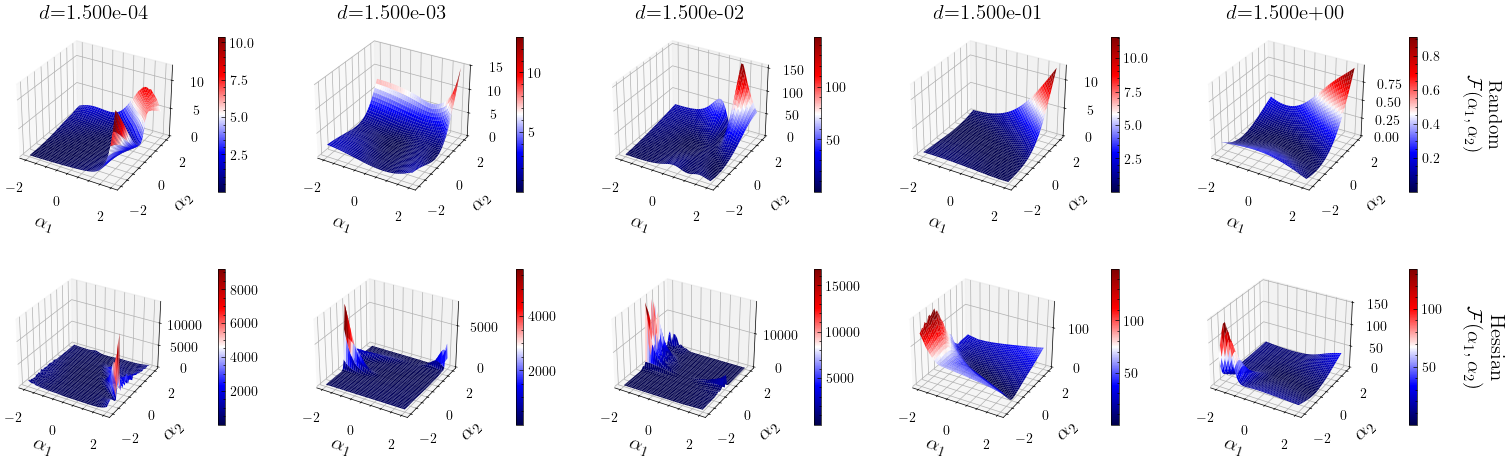

In [19]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(18, 15), subplot_kw={'projection': '3d'})

# Plot the random direction vector subspace projection of the loss landscape
for idx, param in enumerate(PARAM_LIST):
    surf_random = ax[0, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_random[idx]),
        cmap=CMAP,
        linewidth=0,
        antialiased=True
    )
    
    clr_bar1 = fig.colorbar(surf_random, ax=ax[0, idx], shrink=0.10, orientation='vertical', pad=0.15)

    if idx == len(PARAM_LIST) - 1:
        clr_bar1.set_label(
            "Random\n"+r"$\mathcal{F}(\alpha_1, \alpha_2)$",
            fontsize=14,
            rotation=-90,
            labelpad=45
        )

    ax[0, idx].set_xlabel(r'$\alpha_1$', fontsize=14)
    ax[0, idx].set_ylabel(r'$\alpha_2$', fontsize=14)

    # if idx == 0:
    #     ax[0, idx].set_zlabel("Random", labelpad=-90)
    #     ax[0, idx].zaxis.label.set_rotation(90)

    if TOP_PLOT:
        ax[0, idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=15)

    # Plot the Hessian eigenvectors subspace projection of the loss landscape
    surf_hessian = ax[1, idx].plot_surface(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_hessian[idx]),
        cmap=CMAP,
        # vmin=vmin,
        # vmax=vmax,
        linewidth=0,
        antialiased=True
    )

    clr_bar2 = fig.colorbar(surf_hessian, ax=ax[1, idx], shrink=0.10, orientation='vertical', pad=0.2)

    if idx == len(PARAM_LIST) - 1:
        clr_bar2.set_label(
            "Hessian\n"+r"$\mathcal{F}(\alpha_1, \alpha_2)$",
            fontsize=15,
            rotation=-90,
            labelpad=45
        )
    
    ax[1, idx].set_xlabel(r'$\alpha_1$', fontsize=15, labelpad=1.1)
    ax[1, idx].set_ylabel(r'$\alpha_2$', fontsize=15)
    # ax[1, idx].set_zlim(vmin, vmax)

fig.subplots_adjust(left=0.1, right=0.9, hspace=-0.85, top=1.3)

# Output the plots as PDF to the desired directory
loss_landscape_image_name = f"pinn/loss_landscape_random_seed_{SEED}.pdf"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+loss_landscape_image_name, format="pdf", bbox_inches="tight")

plt.show()

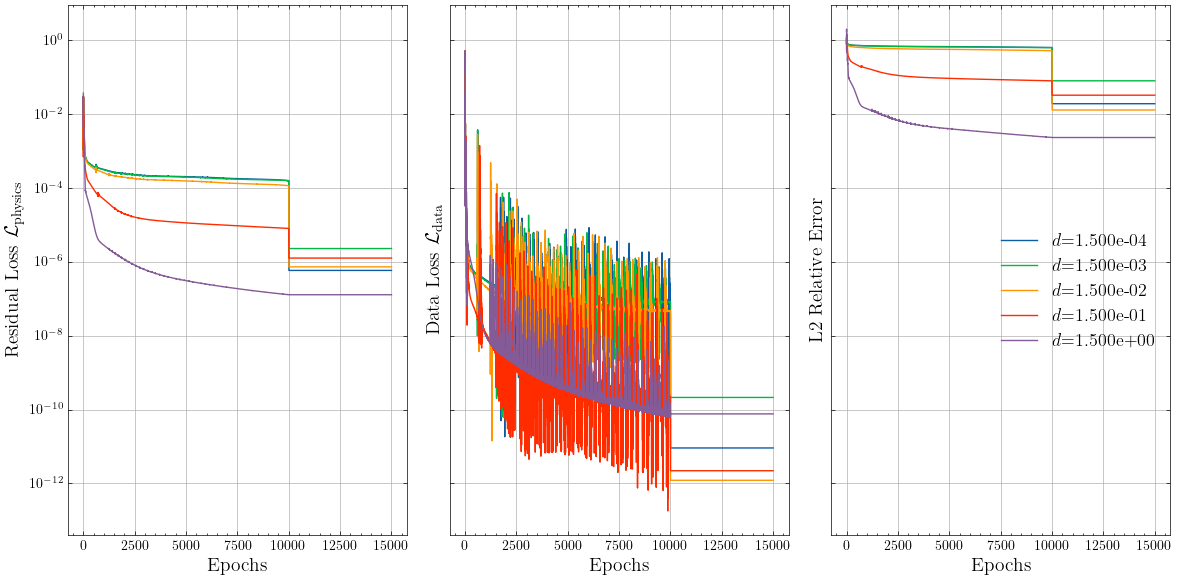

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

# Plot the random direction vector subspace projection of the loss landscape
for residual_loss, init_loss, param, l2_relative in zip(residual_losses_per_param, IC_losses_per_param, PARAM_LIST, test_losses_per_param_per_epoch):
    
    ax[0].semilogy(range(1, EPOCHS+1), residual_loss, label=f"{VARYING_PARAM_NOTATION}={param:.3e}")
    ax[0].set_xlabel("Epochs", fontsize=14)
    ax[0].set_ylabel(r"Residual Loss $\mathcal{L}_{\mathrm{physics}}$", fontsize=14)
    # ax[0].legend(loc="best", fontsize=13)
    ax[0].grid()

    ax[1].semilogy(range(1, EPOCHS+1), init_loss, label=f"{VARYING_PARAM_NOTATION}={param:.3e}")
    ax[1].set_xlabel("Epochs", fontsize=14)
    ax[1].set_ylabel(r"Data Loss $\mathcal{L}_{\mathrm{data}}$", fontsize=14)
    # ax[0].legend(loc="best", fontsize=13)
    ax[1].grid()

    ax[2].semilogy(range(1, EPOCHS+1), l2_relative, label=f"{VARYING_PARAM_NOTATION}={param:.3e}")
    ax[2].set_xlabel("Epochs", fontsize=14)
    ax[2].set_ylabel("L2 Relative Error", fontsize=14)
    ax[2].legend(loc="best", fontsize=13, bbox_to_anchor=(1, 0.6))
    ax[2].grid()

plt.tight_layout()

# # Output the plots as PDF to the desired directory
# loss_landscape_image_name = f"pinn/{VARYING_PARAM}_loss_landscape_random_seed_{SEED}.pdf"

# if SAVE:
#     print("Saving...")
#     plt.savefig(fname=PATH_TO_IM_DIR+loss_landscape_image_name, format="pdf", bbox_inches="tight")

plt.show()

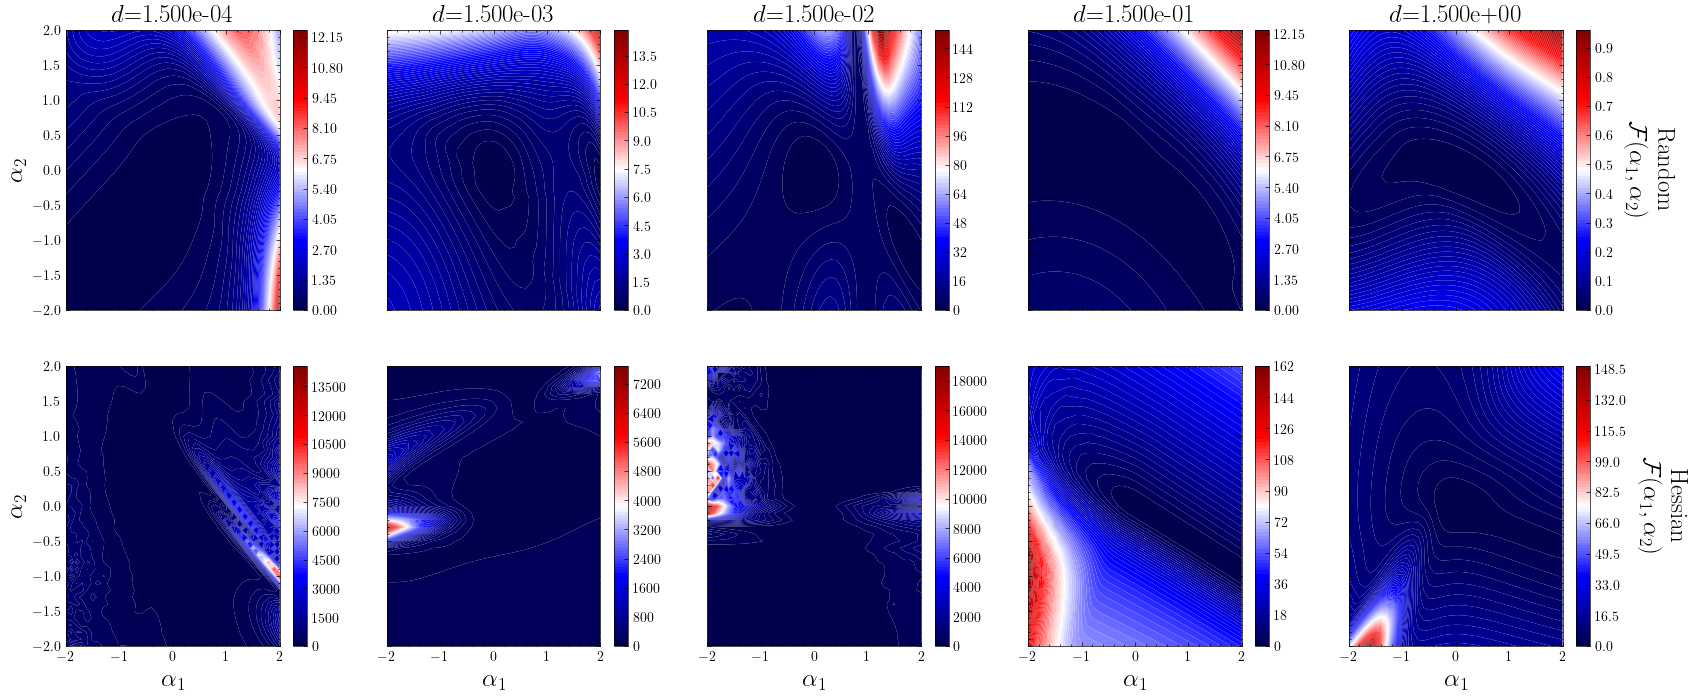

In [21]:
fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(20, 8), sharex=True, sharey=True)

num_levels = 100
# levels = np.linspace(vmin, vmax, num_levels)

for index, (param) in enumerate(PARAM_LIST):
    contour_random = ax[0, index].contourf(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_random[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
    )

    clr_bar1 = fig.colorbar(contour_random, ax=ax[0, index], shrink=1, orientation='vertical', pad=0.05)

    if index == len(PARAM_LIST) - 1:
        clr_bar1.set_label(
            "Random\n"+r"$\mathcal{F}(\alpha_1, \alpha_2)$",
            fontsize=18,
            rotation=-90,
            labelpad=45
        )
    
    if index == 0:
        ax[0, index].set_ylabel(r'$\alpha_2$', fontsize=18)
        ax[1, index].set_ylabel(r'$\alpha_2$', fontsize=18)

    if TOP_PLOT:
        ax[0, index].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=18)


    contour_hessian = ax[1, index].contourf(
        ALPHA_1,
        ALPHA_2,
        (loss_landscapes_hessian[index]),
        cmap=CMAP,
        levels=num_levels,
        antialiased=True
    )

    clr_bar2 = fig.colorbar(contour_hessian, ax=ax[1, index], shrink=1, orientation='vertical', pad=0.05)

    if index == len(PARAM_LIST) - 1:
        clr_bar2.set_label(
            "Hessian\n"+r"$\mathcal{F}(\alpha_1, \alpha_2)$",
            fontsize=18,
            rotation=-90,
            labelpad=45
        )
    
    ax[1, index].set_xlabel(r'$\alpha_1$', fontsize=18)

# Shared colorbar
# cbar = fig.colorbar(contours_pinn[0], ax=ax.ravel().tolist(), shrink=1, orientation='vertical', pad=0.01)

contour_image_name = f"pinn/contour_random_seed_{SEED}.pdf"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+contour_image_name, format="pdf", bbox_inches="tight")

plt.show()

<>:54: SyntaxWarning: invalid escape sequence '\d'
<>:55: SyntaxWarning: invalid escape sequence '\d'
<>:54: SyntaxWarning: invalid escape sequence '\d'
<>:55: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_1440/2115105025.py:54: SyntaxWarning: invalid escape sequence '\d'
  ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_1440/2115105025.py:55: SyntaxWarning: invalid escape sequence '\d'
  ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)


Pred vector shape: torch.Size([2, 201])
Label vector shape: torch.Size([2, 201])
Test times shape: torch.Size([201, 1])
$d$: 0.00015
L2 absolute error: 0.15
L2 relative error: 1.87

$d$: 0.0015
L2 absolute error: 0.62
L2 relative error: 7.80

$d$: 0.015
L2 absolute error: 0.08
L2 relative error: 1.26

$d$: 0.15
L2 absolute error: 0.09
L2 relative error: 3.18

$d$: 1.5
L2 absolute error: 0.00
L2 relative error: 0.23



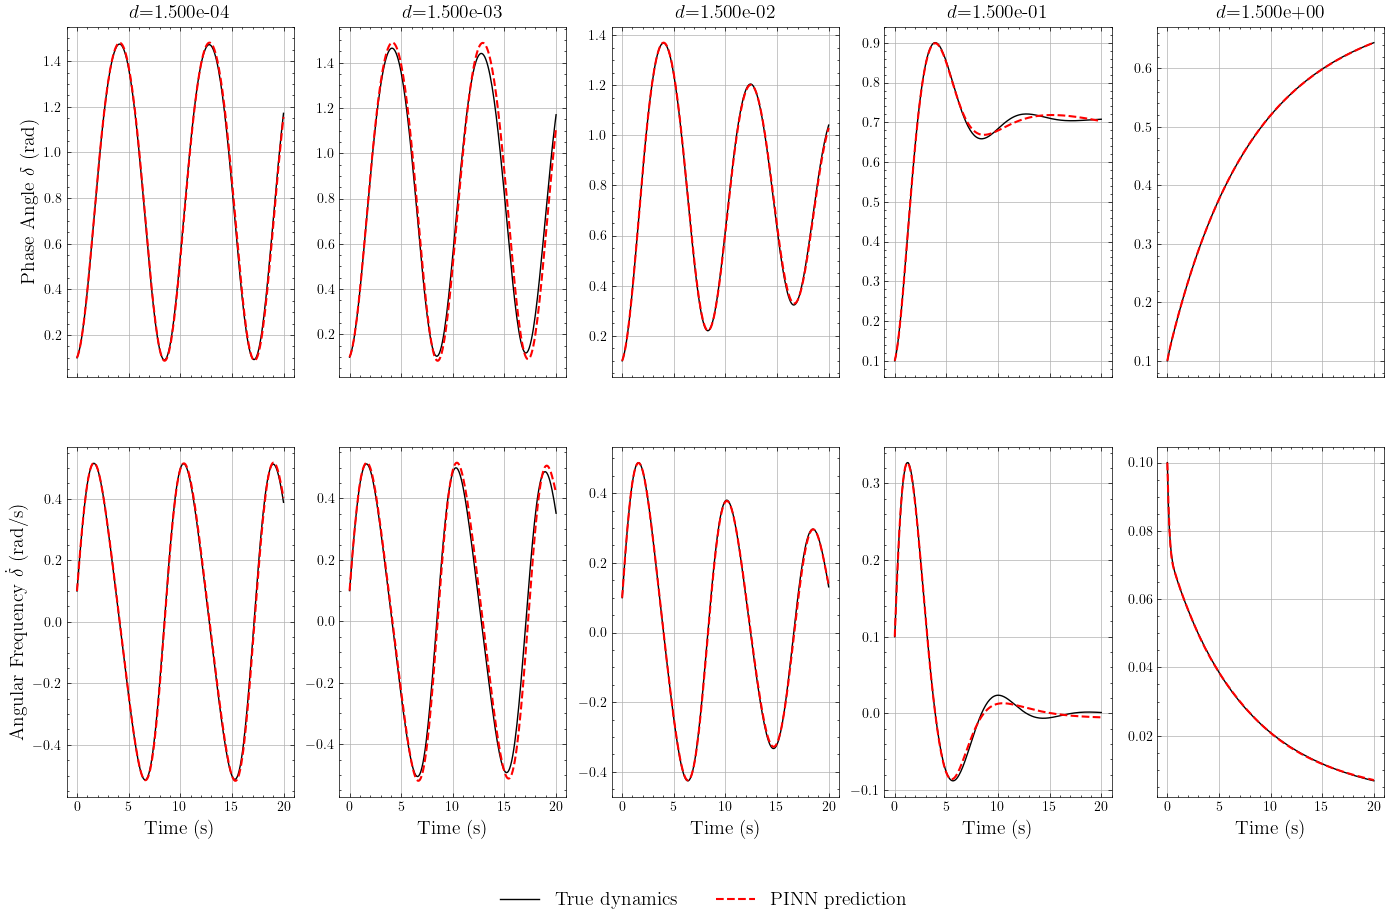

In [22]:
abs_errors_pinns = []
rel_errors_pinns = []
pinn_predictions_per_param = []

fig, ax = plt.subplots(2, len(PARAM_LIST), figsize=(17, 10), sharex=True)

for index, (model, param) in enumerate(zip(pinn_models, PARAM_LIST)):

    phase_angle_labels = numerical_solutions_exact_tensor[index, 0, :]
    angular_frequency_labels = numerical_solutions_exact_tensor[index, 1, :]

    pinn = model
    pinn.eval()
    pred = pinn.forward(data=times_tensor)
    pred_dot = torch.autograd.grad(
        outputs=pred,
        inputs=times_tensor,
        grad_outputs=torch.ones_like(pred),
        create_graph=False,
        retain_graph=False
    )[0]

    pred_vector = torch.stack(tensors=(pred, pred_dot), dim=0).squeeze()
    label_vector = torch.stack(tensors=(phase_angle_labels, angular_frequency_labels), dim=0)

    if index == 0:
        print(f"Pred vector shape: {pred_vector.shape}")
        print(f"Label vector shape: {label_vector.shape}")
        print(f"Test times shape: {times_tensor.shape}")

    l2_abs, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)

    print(f"{VARYING_PARAM_NOTATION}: {param}")
    print(f"L2 absolute error: {l2_abs:.2f}")
    print(f"L2 relative error: {l2_rel*100:.2f}\n")

    abs_errors_pinns.append(l2_abs)
    rel_errors_pinns.append(l2_rel)
    pinn_predictions_per_param.append(pred_vector.detach().numpy())

    ax[0, index].plot(numerical_domain, phase_angle_labels, color="black", linestyle="-", label="True dynamics")
    ax[0, index].plot(numerical_domain, pred.detach().numpy(), color='red', linestyle='--', label='PINN prediction', linewidth=1.5)
    ax[0, index].grid()
    # ax[0, index].legend(fontsize=12, loc="best")
    ax[0, index].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=14)

    ax[1, index].plot(numerical_domain, angular_frequency_labels, color="black", linestyle="-", label="True dynamics")
    ax[1, index].plot(numerical_domain, pred_dot.detach().numpy(), color='red', linestyle='--', label='PINN prediction', linewidth=1.5)
    ax[1, index].grid()
    # ax[1, index].legend(fontsize=12, loc="best")
    ax[1, index].set_xlabel("Time (s)", fontsize=14)

    if index == 0:
        ax[0, index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=14)
        ax[1, index].set_ylabel("Angular Frequency $\dot{\delta}$ (rad/s)", fontsize=14)


# plt.subplots_adjust(left=0.1, right=0.9)
# plt.tight_layout()

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02), fontsize=14)

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    print("Saving...")
    exact_vs_pred_image: str = f"pinn/pinn_vs_ground_truth_seed_{SEED}.pdf"
    plt.savefig(fname=PATH_TO_IM_DIR+exact_vs_pred_image, format="pdf", bbox_inches="tight")

# if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is True) and (DATA_LOSS is False):
#     print("Saving adaptive weight plot...")
#     exact_vs_pred_image: str = f"pinn/pinn_vs_ground_truth_seed_adaptive_wang_2020_seed_{SEED}.pdf"
#     plt.savefig(fname=PATH_TO_IM_DIR+exact_vs_pred_image, format="pdf", bbox_inches="tight")

plt.show()

In [23]:
print(f"Table of relative errors (%) of seed {SEED} and param {VARYING_PARAM} (columns):\n\n{[rel_error.item()*100 for rel_error in rel_errors_pinns]}\n")

Table of relative errors (%) of seed 10 and param damping (columns):

[1.87047328799963, 7.7952370047569275, 1.2641956098377705, 3.1784910708665848, 0.22784406319260597]



In [24]:
if ADAPTIVE_ALGO or R3_ALGO:
    abs_errors_pinns = []
    rel_errors_pinns = []
    pinn_predictions_per_param = []

    fig, ax = plt.subplots(1, len(PARAM_LIST), figsize=(17, 5), sharex=True)

    for index, (model, param) in enumerate(zip(pinn_models, PARAM_LIST)):

        phase_angle_labels = numerical_solutions_exact_tensor[index, 0, :]
        angular_frequency_labels = numerical_solutions_exact_tensor[index, 1, :]

        pinn = model
        pinn.eval()
        pred = pinn.forward(data=times_tensor)
        pred_dot = torch.autograd.grad(
            outputs=pred,
            inputs=times_tensor,
            grad_outputs=torch.ones_like(pred),
            create_graph=False,
            retain_graph=False
        )[0]

        pred_vector = torch.stack(tensors=(pred, pred_dot), dim=0).squeeze()
        label_vector = torch.stack(tensors=(phase_angle_labels, angular_frequency_labels), dim=0)

        if index == 0:
            print(f"Pred vector shape: {pred_vector.shape}")
            print(f"Label vector shape: {label_vector.shape}")
            print(f"Test times shape: {times_tensor.shape}")

        l2_abs, l2_rel = l2_error(pred=pred_vector, ground_truth=label_vector)

        print(f"{VARYING_PARAM_NOTATION}: {param}")
        print(f"L2 absolute error: {l2_abs:.2f}")
        print(f"L2 relative error: {l2_rel*100:.2f}\n")

        abs_errors_pinns.append(l2_abs)
        rel_errors_pinns.append(l2_rel)
        pinn_predictions_per_param.append(pred_vector.detach().numpy())

        ax[index].plot(numerical_domain, phase_angle_labels, color="black", linestyle="-", label="True dynamics")
        ax[index].plot(numerical_domain, pred.detach().numpy(), color='red', linestyle='--', label='PINN prediction', linewidth=1.5)
        ax[index].grid()
        # ax[0, index].legend(fontsize=12, loc="best")
        ax[index].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=22)
        ax[index].set_xlabel("Time (s)", fontsize=22)
        ax[index].tick_params(axis="both", which="major", labelsize=15) 

        if index == 0:
            ax[index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=22)

    plt.tight_layout()

    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15), fontsize=22)

    if SAVE:
        
        if ADAPTIVE_ALGO:
            print("Saving adaptive weight plot...")
            exact_vs_pred_image: str = f"pinn/phase_angle_pinn_vs_ground_truth_adaptive_wang_2023_seed_{SEED}.pdf"
            # exact_vs_pred_image: str = f"pinn/phase_angle_pinn_vs_ground_truth_seed_{SEED}.pdf"
        elif R3_ALGO:
            print("Saving R3 plot...")
            exact_vs_pred_image: str = f"pinn/R3_phase_angle_pinn_vs_ground_truth_seed_{SEED}.pdf"
        
        plt.savefig(fname=PATH_TO_IM_DIR+exact_vs_pred_image, format="pdf", bbox_inches="tight")

    plt.show()

<>:51: SyntaxWarning: invalid escape sequence '\d'
<>:51: SyntaxWarning: invalid escape sequence '\d'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_1440/3592811070.py:51: SyntaxWarning: invalid escape sequence '\d'
  ax[index].set_ylabel("Phase Angle $\delta$ (rad)", fontsize=22)


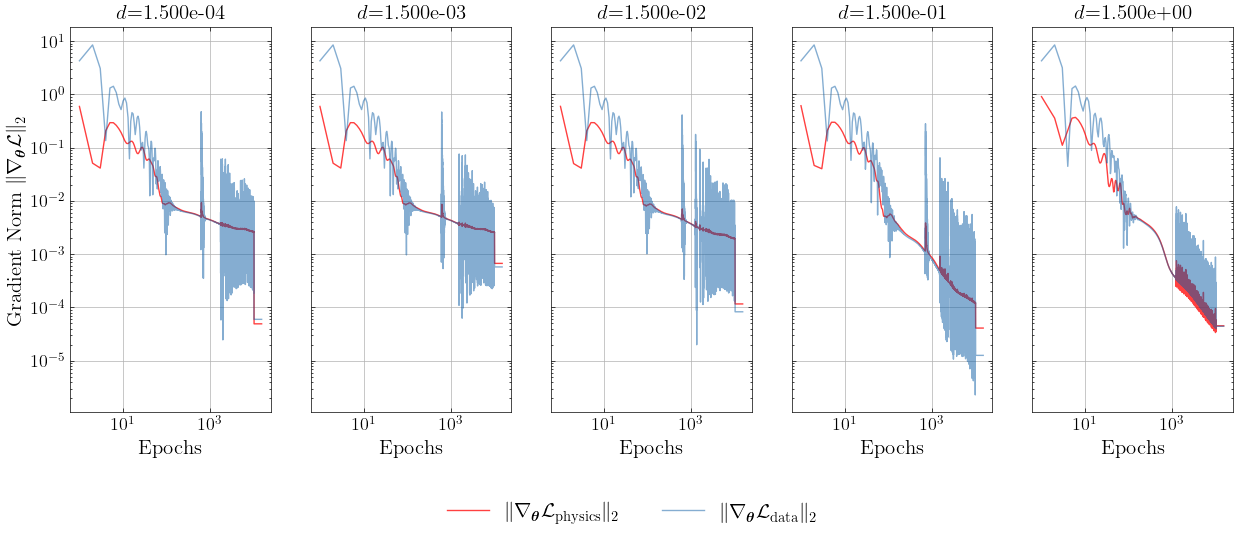

In [25]:
fig, axes = plt.subplots(1, len(PARAM_LIST), figsize=(15, 5), sharey=True)

for idx, param in enumerate(PARAM_LIST):
    axes[idx].loglog(range(1, EPOCHS+1), grad_norm_res_per_param[idx], color="red", alpha=0.75, label=r"$\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{physics}}\rVert_{2}$")
    axes[idx].loglog(range(1, EPOCHS+1), grad_norm_data_per_param[idx], alpha=0.5, label=r"$\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{data}}\rVert_{2}$")
    axes[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=15)
    axes[idx].set_xlabel("Epochs", fontsize=15)
    axes[idx].grid()
    axes[idx].tick_params(axis="both", which="major", labelsize=13) 


    if idx == 0:
        axes[idx].set_ylabel(r"Gradient Norm $\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}\rVert_{2}$", fontsize=15)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15), fontsize=15)

residual_norm_vs_data_norm: str = f"pinn/residual_norm_vs_data_norm_seed_{SEED}.pdf"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+residual_norm_vs_data_norm, format="pdf", bbox_inches="tight")

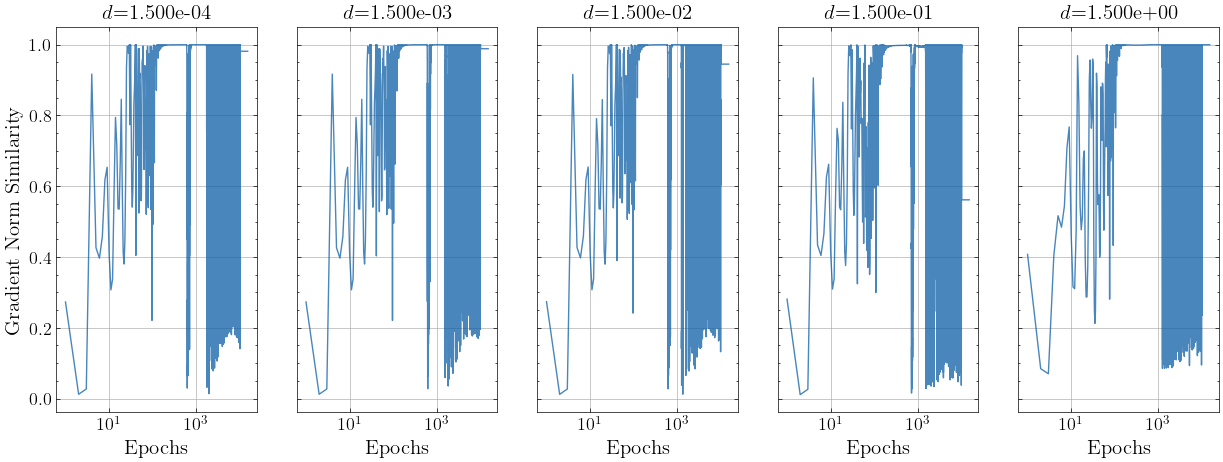

In [26]:
fig, axes = plt.subplots(1, len(PARAM_LIST), figsize=(15, 5), sharey=True)

for idx, param in enumerate(PARAM_LIST):

    grad_magnitude_similarity = [(2 * i * j)/(i**2 + j**2) for i, j in zip(grad_norm_res_per_param[idx], grad_norm_data_per_param[idx])]

    axes[idx].semilogx(range(1, EPOCHS+1), grad_magnitude_similarity, alpha=0.75, label=r"$\lVert \nabla_{\boldsymbol{\theta}}\mathcal{L}_{\mathrm{physics}}\rVert_{2}$")
    axes[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=15)
    axes[idx].set_xlabel("Epochs", fontsize=15)
    axes[idx].grid()
    axes[idx].tick_params(axis="both", which="major", labelsize=13) 


    if idx == 0:
        axes[idx].set_ylabel("Gradient Norm Similarity", fontsize=15)

# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15), fontsize=15)

grad_mag_sim: str = f"pinn/gradient_norm_similarity_seed_{SEED}.pdf"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+grad_mag_sim, format="pdf", bbox_inches="tight")

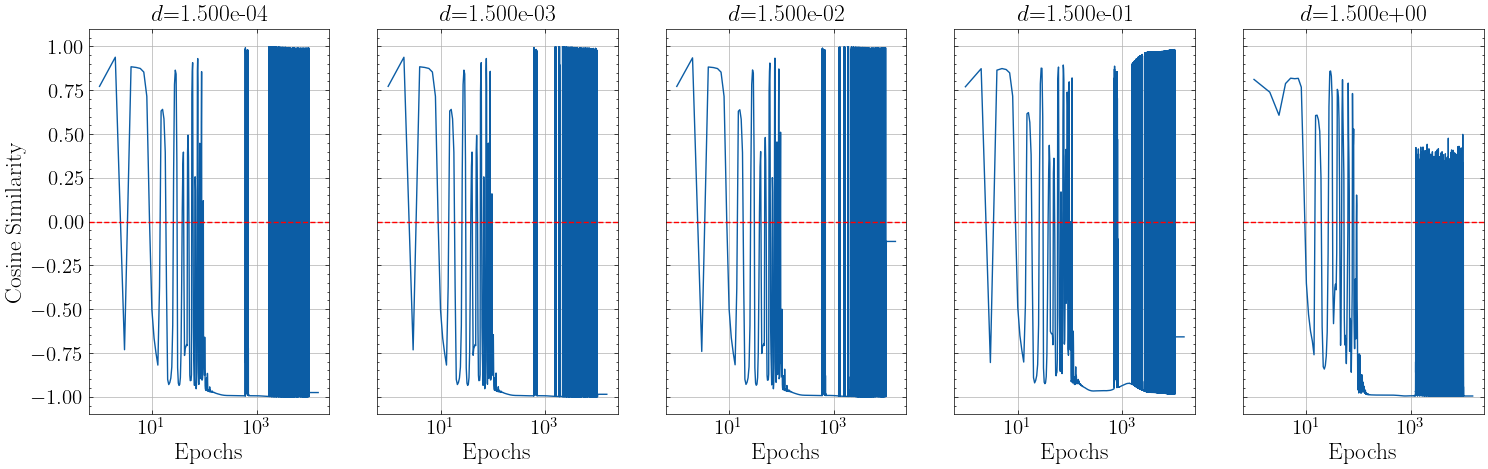

In [27]:
fig, ax = plt.subplots(1, len(PARAM_LIST), figsize=(18, 5), sharey=True)

for idx, param in enumerate(PARAM_LIST):
    ax[idx].semilogx(range(1, EPOCHS+1), cosine_sim_per_param[idx])
    ax[idx].grid()
    ax[idx].set_xlabel("Epochs", fontsize=17)
    ax[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=17)
    ax[idx].tick_params(axis="both", which="major", labelsize=15)
    ax[idx].axhline(0, linestyle="--", color="red")

    if idx == 0:
        ax[idx].set_ylabel("Cosine Similarity", fontsize=17)

cosine_similarity_plot: str = f"pinn/cosine_sim_seed_{SEED}.pdf"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+cosine_similarity_plot, format="pdf", bbox_inches="tight")

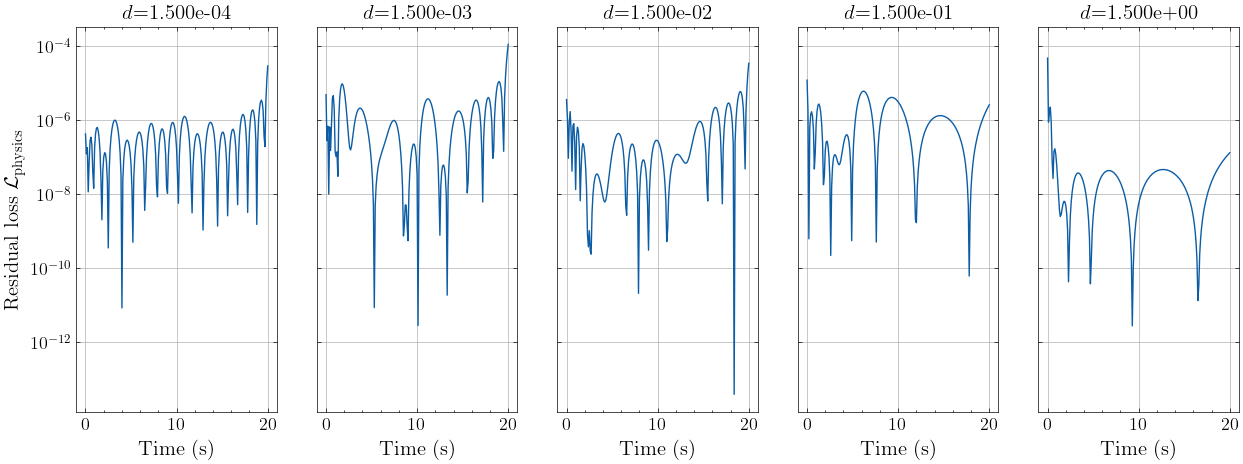

In [28]:
fig, axes = plt.subplots(1, len(PARAM_LIST), figsize=(15, 5), sharey=True)

for idx, param in enumerate(PARAM_LIST):

    DAMPING: torch.Tensor = torch.tensor(data=[[param]])

    pinn = pinn_models[idx]
    
    pinn.eval()
    residual_loss = np.array([physics_based_loss(model=pinn, input=test.clone().detach().requires_grad_(True)).item() for test in times_tensor])
    # skewness_val = skew(a=residual_loss)
    # kurtosis_val = kurtosis(a=residual_loss, fisher=True)

    # print(f"Skewness={skewness_val}\nKurtosis={kurtosis_val}")

    axes[idx].semilogy(times_tensor.detach().numpy(), residual_loss)
    axes[idx].set_xlabel('Time (s)', fontsize=15)
    axes[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=15)
    axes[idx].grid()
    axes[idx].tick_params(axis="both", which="major", labelsize=13) 


    if idx == 0:
        axes[idx].set_ylabel(r'Residual loss $\mathcal{L}_{\mathrm{physics}}$', fontsize=15)
        # axes[1, idx].set_ylabel("Frequency")

    # axes[1, idx].hist(residual_loss, log=False)
    # axes[1, idx].set_xlabel(r'Residual loss $\mathcal{L}_{\mathrm{physics}}$')

residual_fields: str = f"pinn/residual_fields_seed_{SEED}.pdf"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+residual_fields, format="pdf", bbox_inches="tight")

plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_1440/3991582852.py:9: SyntaxWarning: invalid escape sequence '\m'
  axes[idx].loglog(range(1, EPOCHS+1), residual_losses_per_param[idx], color="red", label="$\mathcal{L}_{\mathrm{physics}}$")


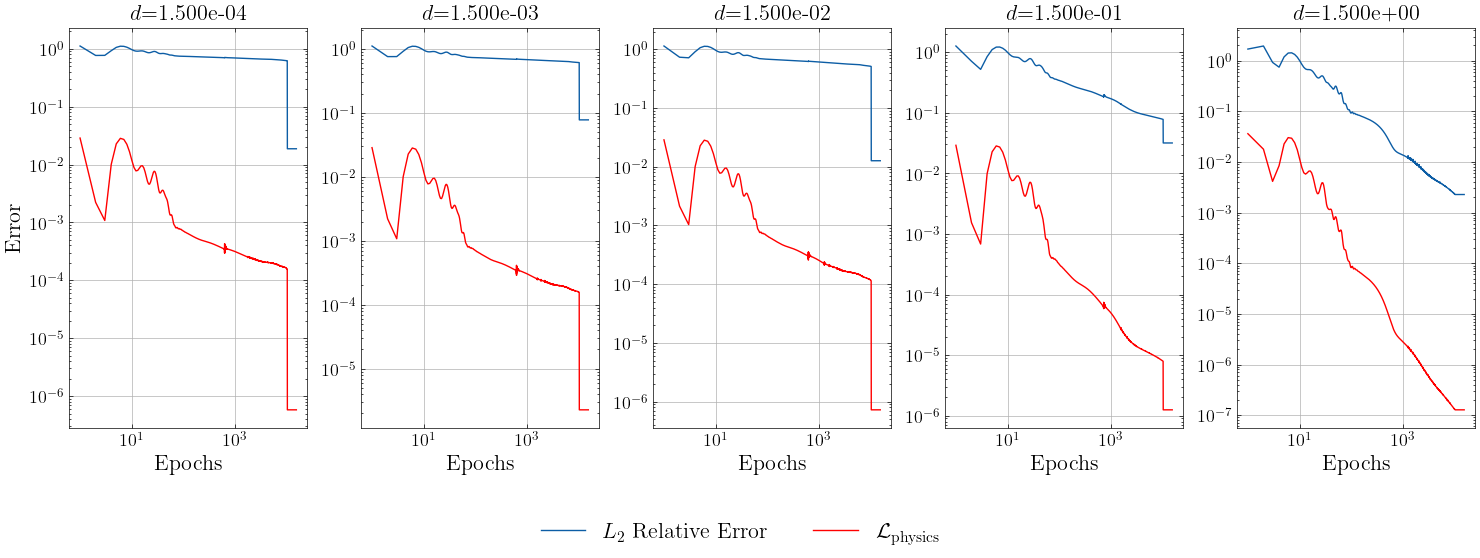

In [30]:
fig, axes = plt.subplots(1, len(PARAM_LIST), figsize=(15, 5))

for idx, param in enumerate(PARAM_LIST):
    # axes_twin = axes[idx].twinx()

    axes[idx].loglog(range(1, EPOCHS+1), test_losses_per_param_per_epoch[idx], label="$L_{2}$ Relative Error")
    axes[idx].set_xlabel('Epochs', fontsize=16)
    axes[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.3e}", fontsize=16)
    axes[idx].loglog(range(1, EPOCHS+1), residual_losses_per_param[idx], color="red", label="$\mathcal{L}_{\mathrm{physics}}$")
    axes[idx].grid()
    axes[idx].tick_params(axis="both", which="major", labelsize=13) 

    # axes[idx].xaxis.set_major_formatter(ScalarFormatter())
    # axes[idx].ticklabel_format(axis="x", style="sci", scilimits=(3,3))

    if idx == 0:
        axes[idx].set_ylabel(r'Error', fontsize=16)
        # axes[1, idx].set_ylabel("Frequency")

    # axes[1, idx].hist(residual_loss, log=False)
    # axes[1, idx].set_xlabel(r'Residual loss $\mathcal{L}_{\mathrm{physics}}$')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15), fontsize=16)
plt.tight_layout()

l2_rel_error_vs_residual_loss: str = f"pinn/l2_rel_error_vs_residual_loss_seed_{SEED}.pdf"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    print("Saving...")
    plt.savefig(fname=PATH_TO_IM_DIR+l2_rel_error_vs_residual_loss, format="pdf", bbox_inches="tight")

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_1440/2294995690.py:8: SyntaxWarning: invalid escape sequence '\m'
  label="Data loss $\mathcal{L}_{\mathrm{data}}$"
/var/folders/4v/ybw0pf9x12l588t0z94snm4c0000gn/T/ipykernel_1440/2294995690.py:16: SyntaxWarning: invalid escape sequence '\m'
  label="Residual loss $\mathcal{L}_{\mathrm{physics}}$"


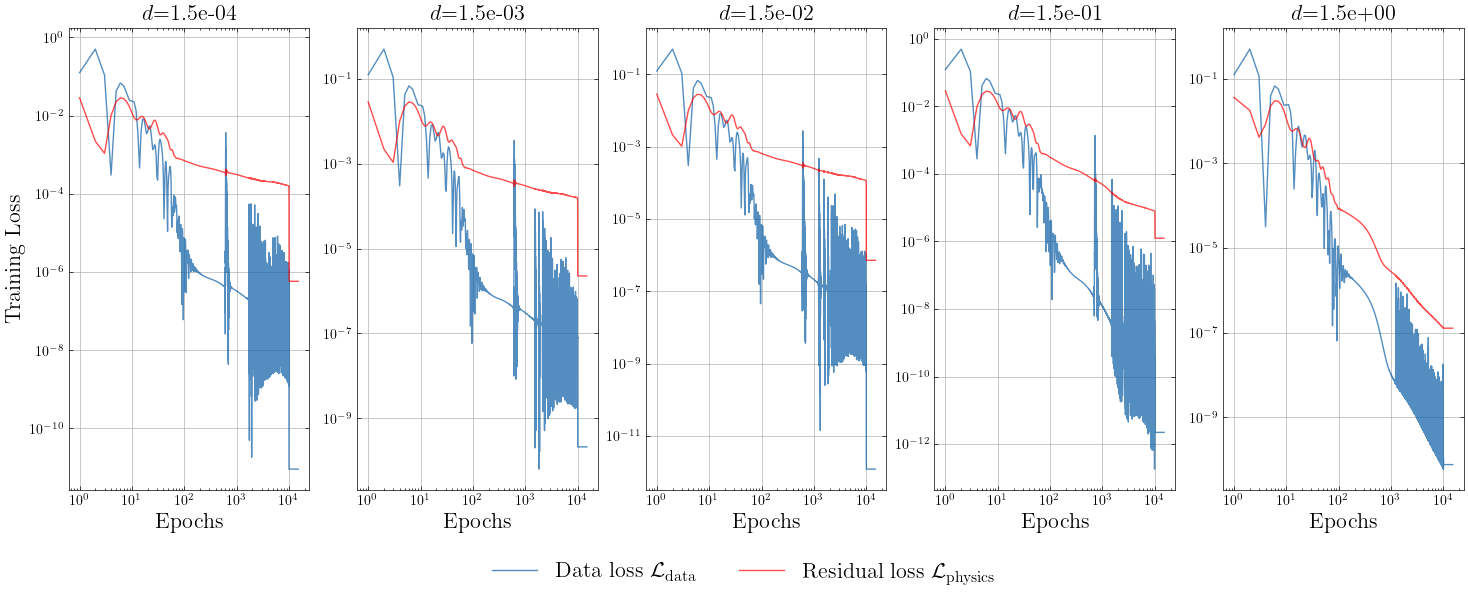

In [32]:
fig, ax = plt.subplots(1, len(PARAM_LIST), figsize=(18, 6))
for idx, param in enumerate(PARAM_LIST):

        ax[idx].loglog(
            range(1, EPOCHS+1),
            IC_losses_per_param[idx],
            alpha=0.7,
            label="Data loss $\mathcal{L}_{\mathrm{data}}$"
        )

        ax[idx].loglog(
            range(1, EPOCHS+1),
            residual_losses_per_param[idx],
            color="red",
            alpha=0.7,
            label="Residual loss $\mathcal{L}_{\mathrm{physics}}$"
        )

        if idx == 0:
            ax[idx].set_ylabel("Training Loss", fontsize=16)

        ax[idx].set_xlabel("Epochs", fontsize=16)
        ax[idx].grid()
        ax[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{param:.1e}", fontsize=16)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.08), fontsize=16)

In [33]:
abs_errors_pinns_export = [err.item() for err in abs_errors_pinns]
rel_errors_pinns_export = [err.item() for err in rel_errors_pinns]

errors_output = f"pinn/l2_errors/abs_rel_errors_seed_{SEED}.npz"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    np.savez(PATH_TO_IM_DIR+errors_output, absolute_errors=abs_errors_pinns_export, relative_errors=rel_errors_pinns_export)

In [34]:
if DATA_LOSS:
    abs_errors_pinns_export = [err.item() for err in abs_errors_pinns]
    rel_errors_pinns_export = [err.item() for err in rel_errors_pinns]

    errors_output = f"pinn/l2_errors/semi_supervised/semi_supervised_abs_rel_errors_seed_{SEED}_Nd_{rand_index.shape[0]}.npz"
    
    np.savez(PATH_TO_IM_DIR+errors_output, absolute_errors=abs_errors_pinns_export, relative_errors=rel_errors_pinns_export)

In [35]:
training_loss_output = f"pinn/training_loss/training_loss_per_epoch_seed_{SEED}.npz"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    np.savez(
        PATH_TO_IM_DIR+training_loss_output,
        total_loss=np.array(training_losses_per_param),
        residual_loss=np.array(residual_losses_per_param),
        data_loss=np.array(IC_losses_per_param)
    )

In [36]:
test_loss_output = f"pinn/rel_error_per_epoch/rel_errors_per_epoch_seed_{SEED}.npz"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    np.savez(
        PATH_TO_IM_DIR+test_loss_output,
        test_loss=np.array(test_losses_per_param_per_epoch)
    )

In [37]:
pinn_predictions_vs_rk45 = f"pinn/pinn_pred_vs_rk45/pinn_pred_vs_rk45_seed_{SEED}.npz"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    np.savez(
        PATH_TO_IM_DIR+pinn_predictions_vs_rk45,
        pred=np.array(pinn_predictions_per_param)[:, 0, :],
        pred_dot=np.array(pinn_predictions_per_param)[:, 1, :]
    )

In [38]:
loss_grad_norms = f"pinn/gradient_norms/loss_grad_norm_per_epoch_seed_{SEED}.npz"

if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is False) and (DATA_LOSS is False):
    np.savez(
        PATH_TO_IM_DIR+loss_grad_norms,
        grad_norms=np.array(gradient_norm_per_param)
    )

In [39]:
np.array(ESD_LIST[0][0]).flatten().shape

(100,)

In [43]:
if ADAPTIVE_ALGO:
    fig, axes = plt.subplots(2, len(PARAM_LIST), figsize=(15, 5))

    for idx, (weight, mean_grad, max_grad) in enumerate(zip(adaptive_weights_per_n_epochs_per_param, mean_gradients_per_param, max_gradients_per_param)):

        axes[0, idx].loglog(range(1, EPOCHS_ADAM+1, 10), mean_grad, label=r"$\overline{|\nabla_{\boldsymbol{\theta}} \mathcal{L}_{\mathrm{physics}}|}$")
        axes[0, idx].loglog(range(1, EPOCHS_ADAM+1, 10), max_grad, color="g", label=r"$\max_{\boldsymbol{\theta}}\Big\{|\nabla_{\boldsymbol{\theta}} \mathcal{L}_{\mathrm{data}}|\Big\}$")
        axes[0, idx].grid()
        axes[0, idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{PARAM_LIST[idx]:.3e}", fontsize=18)
        axes[0, idx].tick_params(axis="both", which="major", labelsize=13)
        
        axes[1, idx].loglog(range(1, EPOCHS_ADAM+1), [lambda_physics[0] for lambda_physics in weight], label=r"$\lambda_{\mathrm{physics}}$", color="red") 
        axes[1, idx].legend(fontsize=16)
        axes[1, idx].set_xlabel("Epochs", fontsize=18)
        axes[1, idx].grid()
        axes[1, idx].tick_params(axis="both", which="major", labelsize=13) 

        if idx == 0:
            axes[0, idx].set_ylabel("Magnitude", fontsize=18)
            axes[1, idx].set_ylabel("Magnitude", fontsize=18)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.18), fontsize=18)
    plt.tight_layout()

    if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is True) and (DATA_LOSS is False):
        print("Saving adaptive weight plot...")
        adpative_weight_diagnosis: str = f"pinn/adaptive_diagnosis_wang_2020_seed_{SEED}.pdf"
        plt.savefig(fname=PATH_TO_IM_DIR+adpative_weight_diagnosis, format="pdf", bbox_inches="tight")

In [41]:
if ADAPTIVE_ALGO:
    fig, axes = plt.subplots(1, len(PARAM_LIST), figsize=(15, 5))

    for idx, (weight) in enumerate(adaptive_weights_per_n_epochs_per_param):

        axes[idx].loglog(range(1, EPOCHS_ADAM+1), [lambda_physics[0] for lambda_physics in weight], label=r"$\lambda_{\mathrm{physics}}$", color="red") 
        axes[idx].loglog(range(1, EPOCHS_ADAM+1), [lambda_physics[1] for lambda_physics in weight], label=r"$\lambda_{\mathrm{data}}$") 
        axes[idx].set_xlabel("Epochs", fontsize=18)
        axes[idx].grid()
        axes[idx].tick_params(axis="both", which="major", labelsize=13) 
        axes[idx].set_title(f'{VARYING_PARAM_NOTATION}='+f"{PARAM_LIST[idx]:.3e}", fontsize=18)

        if idx == 0:
            axes[idx].set_ylabel("Magnitude", fontsize=18)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.18), fontsize=18)
    plt.tight_layout()

    if (SAVE is True) and (R3_ALGO is False) and (ADAPTIVE_ALGO is True) and (DATA_LOSS is False):
        print("Saving adaptive weight plot...")
        adpative_weight_diagnosis: str = f"pinn/adaptive_diagnosis_wang_2023_seed_{SEED}.pdf"
        plt.savefig(fname=PATH_TO_IM_DIR+adpative_weight_diagnosis, format="pdf", bbox_inches="tight")